### 1 - Import test data

In [1]:
#pip install pandas_ta

In [2]:
#pip install backtesting

In [70]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2019-30.09.2022.csv")
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
df=df[df.High!=df.Low]
df.set_index("Gmt time", inplace=True)

In [71]:
df["EMA_slow"]=ta.ema(df.Close, length=50)
df["EMA_fast"]=ta.ema(df.Close, length=30)
df['RSI']=ta.rsi(df.Close, length=10)
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7)
df=df.join(my_bbands)
df

Open     High      Low    Close   Volume  EMA_slow  \
Gmt time                                                                     
2019-09-30 00:00:00  1.09425  1.09426  1.09405  1.09406   585.10       NaN   
2019-09-30 00:05:00  1.09408  1.09414  1.09401  1.09409   289.39       NaN   
2019-09-30 00:10:00  1.09410  1.09423  1.09408  1.09410   276.24       NaN   
2019-09-30 00:15:00  1.09409  1.09410  1.09388  1.09389   439.29       NaN   
2019-09-30 00:20:00  1.09390  1.09395  1.09388  1.09395   341.23       NaN   
...                      ...      ...      ...      ...      ...       ...   
2022-09-30 20:35:00  0.98028  0.98034  0.98001  0.98022   624.12  0.979837   
2022-09-30 20:40:00  0.98023  0.98047  0.98007  0.98030   408.20  0.979855   
2022-09-30 20:45:00  0.98026  0.98034  0.98019  0.98031   317.29  0.979873   
2022-09-30 20:50:00  0.98031  0.98067  0.97987  0.97999  1472.13  0.979878   
2022-09-30 20:55:00  0.98000  0.98066  0.97993  0.98026  1068.81  0.979893   

                     EMA_fast        RSI       ATR  BBL_15_1.5  BBM_15_1.5  \
Gmt time                                                                     
2019-09-30 00:00:00       NaN        NaN       NaN         NaN         NaN   
2019-09-30 00:05:00       NaN        NaN       NaN         NaN         NaN   
2019-09-30 00:10:00       NaN        NaN       NaN         NaN         NaN   
2019-09-30 00:15:00       NaN        NaN       NaN         NaN         NaN   
2019-09-30 00:20:00       NaN        NaN       NaN         NaN         NaN   
...                       ...        ...       ...         ...         ...   
2022-09-30 20:35:00  0.980175  47.042955  0.000423    0.979757    0.980317   
2022-09-30 20:40:00  0.980183  49.010705  0.000420    0.979809    0.980344   
2022-09-30 20:45:00  0.980191  49.272498  0.000381    0.979943    0.980391   
2022-09-30 20:50:00  0.980178  41.666257  0.000441    0.979980    0.980401   
2022-09-30 20:55:00  0.980184  49.041160  0.000482    0.979985    0.980404   

                     BBU_15_1.5  BBB_15_1.5  BBP_15_1.5  
Gmt time                                                 
2019-09-30 00:00:00         NaN         NaN         NaN  
2019-09-30 00:05:00         NaN         NaN         NaN  
2019-09-30 00:10:00         NaN         NaN         NaN  
2019-09-30 00:15:00         NaN         NaN         NaN  
2019-09-30 00:20:00         NaN         NaN         NaN  
...                         ...         ...         ...  
2022-09-30 20:35:00    0.980877    0.114260    0.413104  
2022-09-30 20:40:00    0.980879    0.109099    0.458861  
2022-09-30 20:45:00    0.980838    0.091333    0.409912  
2022-09-30 20:50:00    0.980822    0.085853    0.011308  
2022-09-30 20:55:00    0.980823    0.085378    0.327968  

[224989 rows x 14 columns]

In [72]:
def ema_signal(df, current_candle, backcandles):
    df_slice = df.reset_index().copy()
    # Get the range of candles to consider
    start = max(0, current_candle - backcandles)
    end = current_candle
    relevant_rows = df_slice.iloc[start:end]

    # Check if all EMA_fast values are below EMA_slow values
    if all(relevant_rows["EMA_fast"] < relevant_rows["EMA_slow"]):
        return 1
    elif all(relevant_rows["EMA_fast"] > relevant_rows["EMA_slow"]):
        return 2
    else:
        return 0


df=df[-30000:]
from tqdm import tqdm
tqdm.pandas()
df.reset_index(inplace=True)
df['EMASignal'] = df.progress_apply(lambda row: ema_signal(df, row.name, 7) , axis=1) #if row.name >= 20 else 0

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [02:14<00:00, 223.04it/s]
C:\Users\Bartek\AppData\Local\Temp\ipykernel_5180\670335898.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
def total_signal(df, current_candle, backcandles):
    if (ema_signal(df, current_candle, backcandles)==2
        and df.Close[current_candle]<=df['BBL_15_1.5'][current_candle]
        #and df.RSI[current_candle]<60
        ):
            return 2
    if (ema_signal(df, current_candle, backcandles)==1
        and df.Close[current_candle]>=df['BBU_15_1.5'][current_candle]
        #and df.RSI[current_candle]>40
        ):
    
            return 1
    return 0
        
df['TotalSignal'] = df.progress_apply(lambda row: total_signal(df, row.name, 7), axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [04:53<00:00, 102.18it/s]
C:\Users\Bartek\AppData\Local\Temp\ipykernel_5180\3699091765.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [74]:
#df[df.TotalSignal != 0].head(20)
df[df.TotalSignal != 0]

Gmt time     Open     High      Low    Close   Volume  \
2     2022-05-09 15:35:00  1.05352  1.05442  1.05325  1.05438   736.96   
3     2022-05-09 15:40:00  1.05440  1.05458  1.05407  1.05446   747.64   
4     2022-05-09 15:45:00  1.05447  1.05541  1.05441  1.05504   632.48   
5     2022-05-09 15:50:00  1.05506  1.05596  1.05505  1.05584   835.39   
23    2022-05-09 17:20:00  1.05667  1.05667  1.05608  1.05613  1073.42   
...                   ...      ...      ...      ...      ...      ...   
29939 2022-09-30 15:55:00  0.97908  0.97920  0.97827  0.97828  3394.37   
29940 2022-09-30 16:00:00  0.97829  0.97844  0.97770  0.97774  3895.68   
29941 2022-09-30 16:05:00  0.97773  0.97777  0.97716  0.97729  2656.47   
29942 2022-09-30 16:10:00  0.97728  0.97778  0.97708  0.97750  2686.94   
29980 2022-09-30 19:20:00  0.97974  0.97975  0.97927  0.97957  1842.21   

       EMA_slow  EMA_fast        RSI       ATR  BBL_15_1.5  BBM_15_1.5  \
2      1.053613  1.053527  66.875986  0.000584    1.052178    1.053059   
3      1.053647  1.053587  67.760047  0.000574    1.052156    1.053171   
4      1.053701  1.053681  73.465019  0.000635    1.052099    1.053319   
5      1.053785  1.053820  79.125924  0.000675    1.052111    1.053563   
23     1.055668  1.056334  39.858639  0.000578    1.056482    1.057799   
...         ...       ...        ...       ...         ...         ...   
29939  0.978170  0.978526  43.971934  0.001205    0.978510    0.979718   
29940  0.978153  0.978475  40.264778  0.001139    0.978220    0.979625   
29941  0.978119  0.978398  37.349212  0.001063    0.977807    0.979457   
29942  0.978095  0.978340  39.616366  0.001011    0.977520    0.979325   
29980  0.979407  0.979816  40.601596  0.000581    0.979636    0.980415   

       BBU_15_1.5  BBB_15_1.5  BBP_15_1.5  EMASignal  TotalSignal  
2        1.053941    0.167375    1.249289          1            1  
3        1.054187    0.192824    1.134571          1            1  
4        1.054539    0.231655    1.205446          1            1  
5        1.055016    0.275710    1.283765          1            1  
23       1.059117    0.249083   -0.133571          2            2  
...           ...         ...         ...        ...          ...  
29939    0.980926    0.246564   -0.095290          2            2  
29940    0.981031    0.286879   -0.170855          2            2  
29941    0.981107    0.336945   -0.156520          2            2  
29942    0.981130    0.368638   -0.005609          2            2  
29980    0.981194    0.158892   -0.042217          2            2  

[3434 rows x 17 columns]

In [75]:
import numpy as np
def pointpos(x):
    if x['TotalSignal']==2:
        return x['Low']-1e-3
    elif x['TotalSignal']==1:
        return x['High']+1e-3
    else:
        return np.nan

df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

C:\Users\Bartek\AppData\Local\Temp\ipykernel_5180\2345118794.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



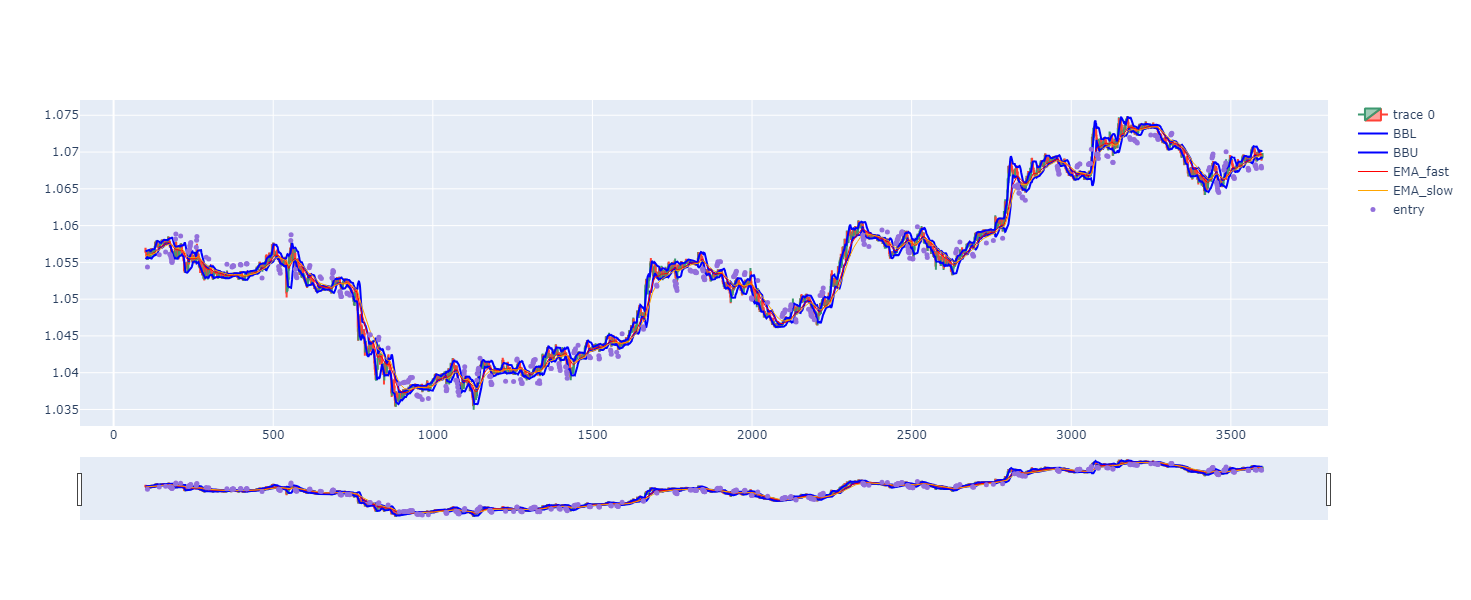

In [76]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+3500]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),

                go.Scatter(x=dfpl.index, y=dfpl['BBL_15_1.5'], 
                           line=dict(color='blue', width=2), 
                           name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_15_1.5'], 
                           line=dict(color='blue', width=2), 
                           name="BBU"),
                go.Scatter(x=dfpl.index, y=dfpl['EMA_fast'], 
                           line=dict(color='red', width=1), 
                           name="EMA_fast"),
                go.Scatter(x=dfpl.index, y=dfpl['EMA_slow'], 
                           line=dict(color='orange', width=1), 
                           name="EMA_slow")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")
fig.update_layout(height=600)
fig.show()

In [77]:
def SIGNAL():
    return df.TotalSignal

In [78]:
from backtesting import Strategy
from backtesting import Backtest

class MyStrat(Strategy):
    mysize = 0.5
    slcoef = 1.1 #1.3
    TPSLRatio = 1.5 # 1.8
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if len(self.trades)>0:
            if self.trades[-1].is_long and self.data.RSI[-1]>=90:
                self.trades[-1].close()
            elif self.trades[-1].is_short and self.data.RSI[-1]<=10:
                self.trades[-1].close()
        
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(df, MyStrat, cash=1000, margin=1/30, commission=0.00)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 26)],
                    TPSLRatio=[i/10 for i in range(10, 26)], 
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

C:\Users\Bartek\AppData\Local\Temp\ipykernel_5180\2073779777.py:33: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



  0%|          | 0/8 [00:00<?, ?it/s]

Start                                     0.0
End                                   29999.0
Duration                              29999.0
Exposure Time [%]                   32.593333
Equity Final [$]                   4115.27167
Equity Peak [$]                   4217.945433
Return [%]                         311.527167
Buy & Hold Return [%]                -6.93528
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -24.222395
Avg. Drawdown [%]                   -2.273415
Max. Drawdown Duration                 3843.0
Avg. Drawdown Duration             158.122807
# Trades                               1671.0
Win Rate [%]                        43.985637
Best Trade [%]                        0.40522
Worst Trade [%]                     -0.252185
Avg. Trade [%]                    

In [79]:
bt.plot()

GridPlot(id='p1635', ...)

In [80]:
stats["_strategy"]

<Strategy MyStrat(slcoef=1.1,TPSLRatio=1.5)>

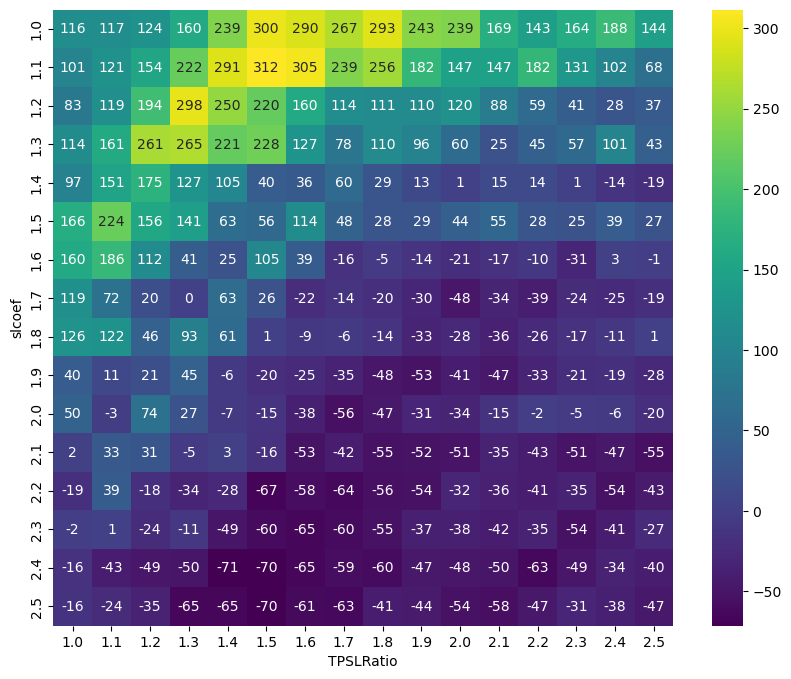

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()